### **VISIÓN POR COMPUTADORA: CLASIFICACIÓN DE IMÁGENES DE FLORES**

**Aspectos teóricos del capítulo**
1. Carga y preprocesamiento del dataset.
2. Definición de una red convolucional desde cero.
3. Entrenamiento y evaluación.
4. Mitigación del sobreajuste: Aumentación de datos y regularización.
5. Uso de modelos preentrenados con VGG16.
6. Ajuste fino (Fine-Tuning).

### **1. Instalación de librerías**
Se importan las librerías/módulos necesarios para la implementación del proceso de visión por computadora:
* **tensorflow:** Para construir el modelo de redes neuronales.
* **tensorflow_datasets:** Para cargar el dataset Flowers de TensorFlow.
* **to_categorical:** Función de Keras que convierte etiquetas numéricas en formato one-hot encoding.
* **Sequential:** Es una clase de Keras para construir modelos lineales (capa por capa, en el orden en que se añaden).
* **Conv2D:** Capa de convolución 2D, es utilizada para extraer características de las imágenes (como bordes, texturas, formas).
* **MaxPooling2D:** Capa de pooling, reduce las dimensiones de las características para simplificar la información y evitar sobreajuste.
* **Flatten:** Aplana las características extraídas por las capas convolucionales para prepararlas para una capa densa.
* **Dense:** Capa que aprende a clasificar las características extraídas.
* **Dropout:** Capa que apaga aleatoriamente algunas neuronas durante el entrenamiento para prevenir sobreajuste.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

#### **2. Carga del Dataset**
Se carga el dataset **tf_flowers** de TensorFlow utilizando la función **tfds.load** y se le pasan los parámetros:

* **split:** Divide los datos en tres subconjuntos:
    * El 70% de los datos para entrenamiento. **train[:70%]**
    * El 15% de los datos para validación. **train[70%:85%]:**
    * El 15% de los datos para prueba. **train[85%:]**
 
* **as_supervised=True:** Devuelve los datos como pares (imagen, etiqueta).
* **with_info=True:** Devuelve información adicional del dataset (como el número de clases) en la variable info.

Luego, obtiene el número de clases (tipos) y se muestra algunos de las flores que contiene el dataset.

Número de clases: 5


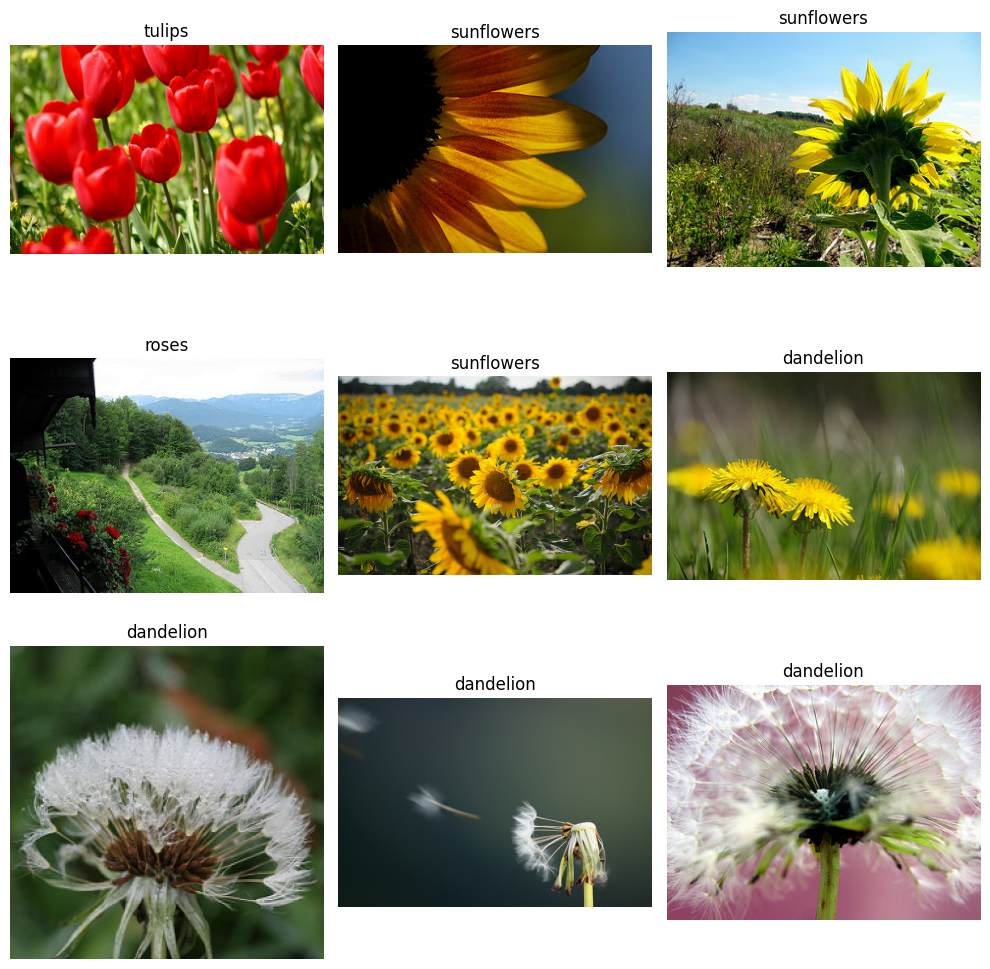

In [2]:
(train_data, val_data, test_data), info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    as_supervised=True,
    with_info=True
)

num_classes = info.features['label'].num_classes
print(f"Número de clases: {num_classes}")

class_names = info.features['label'].int2str

num_images = 9
grid_size = int(num_images ** 0.5)

plt.figure(figsize=(10, 10))

for i, (image, label) in enumerate(train_data.take(num_images)):
    plt.subplot(grid_size, grid_size, i + 1)
    plt.imshow(image)
    plt.title(class_names(label.numpy()))
    plt.axis('off')

plt.tight_layout()
plt.show()


#### **3. Preprocesamiento del Dataset**
Se prepara los datos del dataset aplicando un preprocesamiento a las imágenes y etiquetas antes de entrenar un modelo.
* **img_size:** Se define una tupla con el tamaño que se usará para redimensionar todas las imágenes (128x128 píxeles), esto con el fin de lograr consistencia en las entradas del modelo.
* **preprocess:** Se define una función que devuelve cada una de las imagen procesadas y con sus etiquetas en formato One-Hot:
    * **tf.cast:** Convierte las imágenes a tipo float32 para que se puedan dividir correctamente entre 255.0 al momento de la normalización.
    * **tf.ensure_shape:** Verifica que cada imagen tenga 3 canales (RGB).
    * **tf.image.resize:** Redimensiona la imagen al tamaño establecido.
    * **Normalización** Cada valor de píxel se divide entre 255.0 para que estén en el rango [0, 1], lo que ayuda al modelo a entrenarse de manera más eficiente porque los valores son pequeños y consistentes.
    * **tf.cast:** Convierte las etiquetas a enteros (tipo int32).
    * **tf.one_hot:** Transforma las etiquetas en un vector binario One-Hot. 2 --> [0, 0, 1, 0, 0]


In [3]:
img_size = (128, 128)

def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.ensure_shape(image, (None, None, 3))
    image = tf.image.resize(image, img_size)
    image = image / 255.0

    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)

    return image, label

Luego, se aplica el preprocesamiento a cada uno de los conjuntos:
* **map(preprocess):** Aplica la función preprocess a cada imagen y etiqueta del dataset.
* **batch(32):** Agrupa las muestras en lotes de 32, ya que esto mejora la eficiencia de entrenamiento del modelo.
* **shuffle(1000):** Mezcla las imágenes aleatoriamente para que el modelo no aprenda patrones del orden de los datos.

In [4]:
train_data = train_data.map(preprocess).batch(32).shuffle(1000)
val_data = val_data.map(preprocess).batch(32)
test_data = test_data.map(preprocess).batch(32)

#### **4. Definición de un modelo de Red Neuronal Convucional (CNN)**
El modelo se componen de 7 capas, las cuales son:

* **Capa de Convolución (Conv2D):**  
  * Esta capa utiliza **32 filtros** pequeños de tamaño **3x3** para recorrer la imagen y detectar **patrones básicos**, como bordes o colores.
  * **ReLU (Rectified Linear Unit):** Una función que **convierte los valores negativos en 0**, ayudando a que solo se mantengan las características importantes. 
  * **Tamaño de la imagen esperado**: El modelo espera imágenes de **128x128 píxeles con 3 canales** (RGB - Rojo, Verde, Azul).

* **Capa de Pooling (MaxPooling2D):**  
  * Reduce el tamaño de la imagen utilizando una **ventana de 2x2** y seleccionando el **valor máximo** en cada región. Esto ayuda a que la red sea **más eficiente**, ya que simplifica la información conservando solo las partes más importantes.

* **Segunda Capa de Convolución:**  
  * Aplica **64 filtros de 3x3** sobre la imagen ya simplificada por la primera capa de pooling. Esto con el fin de detectar **patrones más complejos** como formas y texturas.  
  * **ReLU** Se usa para mantener la información relevante y descartar los valores negativos.

* **Segunda Capa de Pooling:**  
  * Nuevamente se aplica **MaxPooling** con una ventana de **2x2**. Para que a medida que avanza el modelo, más se **reduce el tamaño** de los datos, haciendo que el procesamiento sea más rápido y evitando que la red memorice en lugar de aprender.

* **Tercera Capa de Convolución:**  
  * Aplica **128 filtros de 3x3**. Esta capa se enfoca en **detectar patrones más específicos** como combinaciones de formas y texturas.

* **Capa de Aplanamiento (Flatten):**  
  * Convierte la salida de las capas anteriores en un **vector unidimensional**. Esto se hace porque als capas densas (fully connected) solo pueden trabajar con vectores, no con estructuras tridimensionales.

* **Capa Densa (Fully Connected):**  
  * Esta capa contiene **128 neuronas** y está completamente conectada con todas las neuronas de la capa anterior. Esta capa lo que hace es **combinar todas las características detectadas hasta este punto y aprender de estos patrones**.

* **Capa Dropout:**  
  * Apaga aleatoriamente **50% de las neuronas** durante cada paso del entrenamiento. Esto evita que la red memorice los datos de entrenamiento, lo que podría afectar su capacidad para generalizar con datos nuevos (sobreajuste).

* **Capa de Salida:**  
  * Esta capa tiene **una neurona por clase** en el problema de clasificación.  
  * **Softmax** convierte las salidas de la capa en **probabilidades**. La clase con la mayor probabilidad será la predicción final del modelo.


In [5]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

c:\Users\1234\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Luego, se compila el modelo:
* **optimizer='adam':** El optimizador Adam ajusta los pesos del modelo durante el entrenamiento.
* **loss='categorical_crossentropy':** Esta función de pérdida se usa para problemas de clasificación multi-clase con etiquetas en formato One-Hot.
* **metrics=['accuracy']:** Utilizamos exactitud (accuracy) para medir el rendimiento del modelo durante el entrenamiento.

In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### **5. Entrenamiento del modelo**
Se entrena el modelo utilizando el método **fit()** y utilizando:
* **Datos de entrenamiento (train_data):** Para que el modelo aprende ajustando sus pesos.
* **Datos de validación (val_data):** Para evaluar el rendimiento del modelo en datos que no ha visto durante el entrenamiento. Esto ayuda a detectar sobreajuste (cuando el modelo memoriza en lugar de aprender).
* **epochs:** Son una pasada completa por todos los datos del conjunto de entrenamiento, en este caso, el modelo repetirá este proceso 10 veces, ajustando sus pesos en cada epoch para mejorar la predicción.

In [7]:
history = model.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10


81/81 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.3231 - loss: 1.7680 - val_accuracy: 0.4574 - val_loss: 1.2604
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 34s 392ms/step - accuracy: 0.4630 - loss: 1.2529 - val_accuracy: 0.5281 - val_loss: 1.1211
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 31s 376ms/step - accuracy: 0.5642 - loss: 1.1008 - val_accuracy: 0.6116 - val_loss: 0.9717
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 33s 396ms/step - accuracy: 0.6267 - loss: 0.9828 - val_accuracy: 0.6207 - val_loss: 0.9751
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 32s 385ms/step - accuracy: 0.6579 - loss: 0.8646 - val_accuracy: 0.6189 - val_loss: 0.9542
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 33s 380ms/step - accuracy: 0.7112 - loss: 0.7524 - val_accuracy: 0.6025 - val_loss: 0.9774
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 31s 367ms/step - accuracy: 0.7468 - loss: 0.6332 - val_accuracy: 0.6407 - val_loss: 1.0074
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 30s 363ms/step - accuracy: 0.7942 - loss: 0.5386 - val_accuracy: 0.598

In [8]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Pérdida en prueba: {test_loss}")
print(f"Precisión en prueba: {test_accuracy}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.6388 - loss: 1.2422
Pérdida en prueba: 1.2045258283615112
Precisión en prueba: 0.6454545259475708


### **6. Aumento de Datos (Data Augmentation)**

El **aumento de datos (Data Augmentation)** es una técnica que genera **nuevas versiones ligeramente modificadas de las imágenes originales**, lo que ayuda al modelo a **generalizar mejor** y evitar **sobreajuste**.

* **ImageDataGenerator:** Crea un objeto que aplica aumentos de datos al dataset de imágenes, generando variaciones aleatorias para que el modelo sea más robusto.
    * **rotation_range=20:** Aplica una rotación aleatoria de hasta 20 grados a las imágenes.
    * **width_shift_range=0.1:** Desplaza las imágenes horizontalmente hasta un 10% del ancho.
    * **height_shift_range=0.1:** Desplaza las imágenes verticalmente hasta un 10% de la altura.
    * **horizontal_flip=True:** Voltea las imágenes horizontalmente de manera aleatoria.

    * **tf.squeeze(image):** Elimina dimensiones adicionales de la imagen, asegurando que tenga la forma [altura, anchura, canales] antes de aplicar las transformaciones.

* **Función de aumentos de datos**
    * **random_flip_left_right y random_flip_up_down:** Realizan volteos horizontales y verticales aleatorios.
    * **random_brightness y random_contrast:** Ajustan el brillo y el contraste aleatoriamente para simular diferentes condiciones de iluminación.
    * **resize_with_crop_or_pad seguido de random_crop:** Añaden un borde alrededor de la imagen (padding) y luego recortan aleatoriamente para simular desplazamientos.
    * **Normalización:** Escala los valores de los píxeles a un rango de [0, 1], lo cual es beneficioso para el entrenamiento.

In [9]:
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

def augment(image, label):
    image = tf.squeeze(image)

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.resize_with_crop_or_pad(image, img_size[0] + 10, img_size[1] + 10)
    image = tf.image.random_crop(image, size=[img_size[0], img_size[1], 3])

    image = tf.cast(image, tf.float32) / 255.0
    
    return image, label

augmented_train_data = train_data.map(augment).batch(32).shuffle(1000)

Se compila el modelo:
* **train_data.map(augment):** Aplica la función augment a cada imagen y etiqueta en el conjunto de entrenamiento.
* **batch(32):** Agrupa las imágenes en lotes de 32, lo cual es útil para el procesamiento paralelo en el entrenamiento.
* **shuffle(1000):** Mezcla las imágenes de entrenamiento para evitar que el modelo aprenda el orden en que están dispuestas.

Se entrena el modelo:
* **optimizer='adam':** El optimizador Adam ajusta los pesos del modelo para minimizar el error de predicción.
* **loss='sparse_categorical_crossentropy':** La función de pérdida para clasificación de múltiples clases (sin codificación One-Hot de las etiquetas).
* **metrics=['accuracy']:** Utiliza la precisión como métrica para evaluar el rendimiento del modelo.

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    augmented_train_data,
    epochs=10,
    validation_data=val_data
)

test_loss, test_accuracy = model.evaluate(test_data)
print(f"Pérdida en prueba: {test_loss}")
print(f"Precisión en prueba: {test_accuracy}")

### **7. Uso de Modelos Preentrenados (Transfer Learning)**
Se utiliza el modelo preentrenado VGG16 como una base para construir un modelo de clasificación de las imágenes. VGG16 ha sido entrenado previamente en el conjunto de datos ImageNet.
* **weights='imagenet':** Carga los pesos preentrenados de VGG16, entrenados en el conjunto de datos ImageNet.
* **include_top=False:** Excluye las capas de clasificación finales del modelo original de VGG16, permitiendo añadir tus propias capas para clasificar según las clases de tu dataset.
* **input_shape=(128, 128, 3):** Define el tamaño de entrada para las imágenes. Aquí el tamaño es de 128x128 píxeles con 3 canales de color (RGB).
* **trainable = False:** Congela los pesos del modelo base de VGG16 para evitar que se ajusten durante el entrenamiento, lo que ahorra tiempo y recursos computacionales. Así, el modelo utiliza sus características preentrenadas para ayudar en la clasificación sin modificar las capas internas.

**Construcción del modelo**  
Este nuevo modelo utiliza VGG16 como extractor de características y se le agrega capas adicionales para personalizar la salida según el número de clases (5) de nuestra clasificaión de imágenes de flores:

* **Flatten():** Convierte la salida tridimensional de VGG16 en un vector unidimensional para que pueda pasar a las capas densas.
* **Dense(128, activation='relu'):** Capa totalmente conectada con 128 neuronas y función de activación ReLU para aprender combinaciones complejas de las características extraídas.
* **Dropout(0.5):** Desactiva aleatoriamente el 50% de las neuronas en cada paso del entrenamiento, ayudando a reducir el sobreajuste.
* **Dense(num_classes, activation='softmax'):** Capa de salida que genera una distribución de probabilidad sobre las clases. La función softmax asegura que la suma de las probabilidades sea 1, ideal para clasificación multiclase.

In [10]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg_base.trainable = False

model = Sequential([
    vgg_base,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,037 (60.14 MB)

 Trainable params: 1,049,349 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### **8. Ajuste Fino (Fine-Tuning)**
El ajuste fino es una técnica que permite ajustar algunas capas de un modelo preentrenado (VGG16) para mejorar su rendimiento en un nuevo conjunto de datos.
* **vgg_base.trainable = True:** Habilita el entrenamiento en todas las capas del modelo VGG16. Esto significa que el modelo ahora podrá ajustar los pesos de estas capas, aunque en el siguiente paso limitaremos las capas que realmente se entrenarán.
* **for layer in vgg_base.layers[:-4]:** Recorre todas las capas de VGG16 excepto las últimas cuatro ([:-4]).
* **layer.trainable = False:** Congela todas las capas excepto las últimas cuatro, manteniendo sus pesos sin cambios. Solo se entrenarán las últimas cuatro capas de VGG16, permitiendo que el modelo ajuste estas capas para adaptarse mejor a los datos específicos sin modificar la mayoría de las características que ya ha aprendido en el conjunto de datos ImageNet.

Se compila:
* **optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5):** Utiliza el optimizador RMSprop con una tasa de aprendizaje muy baja (1e-5). Esta tasa baja es crucial para el ajuste fino, ya que permite que los pesos de las últimas capas se ajusten de manera gradual y evita modificaciones abruptas que puedan destruir las características preentrenadas de VGG16.
* **loss='categorical_crossentropy':** La función de pérdida categorical_crossentropy es adecuada para problemas de clasificación multiclase cuando las etiquetas están en formato One-Hot.
* **metrics=['accuracy']:** Evalúa el rendimiento del modelo usando la precisión.

In [ ]:
vgg_base.trainable = True

for layer in vgg_base.layers[:-4]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_data, validation_data=val_data, epochs=10)


Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - accuracy: 0.2776 - loss: 1.6344 - val_accuracy: 0.6352 - val_loss: 1.0932
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 253s 3s/step - accuracy: 0.5715 - loss: 1.1144 - val_accuracy: 0.7405 - val_loss: 0.8021
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.7036 - loss: 0.8308 - val_accuracy: 0.7931 - val_loss: 0.6445
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - accuracy: 0.7517 - loss: 0.6727 - val_accuracy: 0.7895 - val_loss: 0.5832
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - accuracy: 0.8058 - loss: 0.5472 - val_accuracy: 0.8058 - val_loss: 0.5341
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 240s 3s/step - accuracy: 0.8446 - loss: 0.4705 - val_accuracy: 0.8240 - val_loss: 0.5050
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 238s 3s/step - accuracy: 0.8651 - loss: 0.3997 - val_accuracy: 0.8294 - val_loss: 0.4899
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step - accuracy: 0.8867 - loss: 0.3591 - val_accuracy: 0.8439 - v

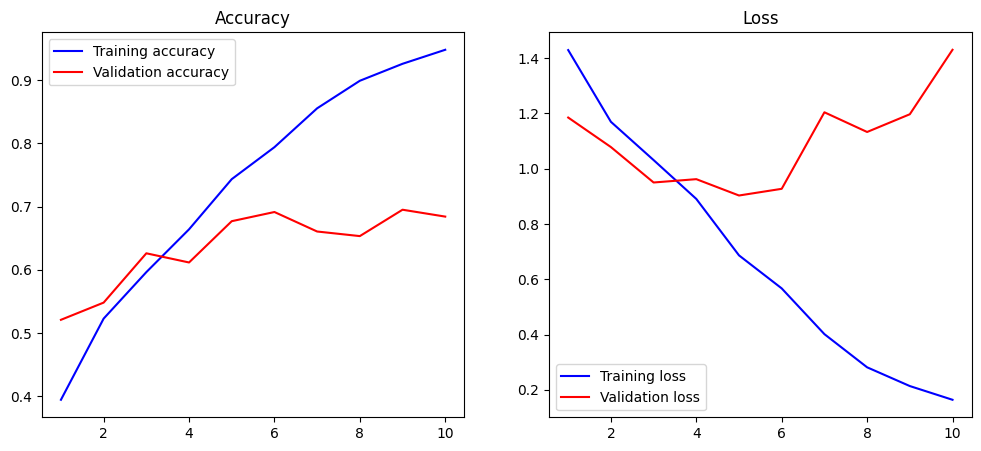

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()

plt.show()